Does the map output include depth of truncated water columns?

 - NetNode_z does not have the quantized depths
 - FlowElem_zcc does not have the quantized depths
 - FlowElem_bl does not have the quantized depths
 - waterdepth is not quantized
 - DWAQ output, with volumes and planform area, *does* include stairstepping.

This is all from a run with mdu['numerics','Keepzlayeringatbed']=1
which I think produces stairstepped beds.

Based on the depths in DWAQ output compared to incoming FlowElem_bl values,
DFM is extending layers out to the next deeper layer elevation. 
(FlowElem_bcc showed some missing data on the NW corner, unclear why).



In [2]:
import xarray as xr
import numpy as np
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
from stompy import utils
from stompy.model.delft import dfm_grid
import stompy.model.delft.waq_scenario as waq
import stompy.model.delft.io as dio
from stompy.spatial import proj_utils
utm2ll=proj_utils.mapper('EPSG:26910','WGS84')
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
mdu=dio.MDUFile('runs/short_29/short_29.mdu')
eta0=float( mdu['geometry','WaterLevIni'] )

In [114]:
try:
    map_ds.close()
except NameError:
    pass
map_ds=xr.open_dataset('runs/short_29/DFM_OUTPUT_short_29/short_29_map.nc')

# Do I want the grid from the net file, or the original?
g=dfm_grid.DFMGrid(map_ds)

In [94]:
# elif 'hycom' in coastal_source:
from sfb_dfm_utils import hycom, ca_roms

coastal_pad=np.timedelta64(10,'D') # lots of padding to avoid ringing from butterworth
_,run_start,run_stop=mdu.time_range()
coastal_time_range=[run_start-coastal_pad,run_stop+coastal_pad]

hycom_lon_range=[-124.7, -121.7 ]
hycom_lat_range=[36.2, 38.85]

coastal_files=hycom.fetch_range(hycom_lon_range,hycom_lat_range,coastal_time_range)

In [95]:
coastal_bc_coords=[ [450980., 4291405.], # northern
                    [595426., 4037083.] ] # southern
if coastal_bc_coords is not None:
    candidate_nodes=g.select_nodes_boundary_segment(coastal_bc_coords)
    candidates=[ g.nodes_to_edge( [a,b] )
                 for a,b in zip(candidate_nodes[:-1],
                                candidate_nodes[1:]) ]
    candidates=np.array(candidates)
else:
    candidates=None # !? danger will robinson.

ca_roms.annotate_grid_from_data(g,coastal_files,candidate_edges=candidates)

boundary_edges=np.nonzero( g.edges['src_idx_out'][:,0] >= 0 )[0]


INFO:root:/opt/data/delft/cache/hycom/2017062100--124.70_-121.70_36.20_38.85.nc
INFO:root:Will assume wet-cells in first time step true for eternity
INFO:ca_roms:0/7676


In [96]:
# Get the boundary locations ready for OTPS
from stompy.model import otps
Otps=otps.otps_model.OTPS('/home/rusty/src/otps/OTPS2', # Locations of the OTPS software                                                                                             
                          '/opt/data/otps') # location of the data
                                                                                                                                                    
# the way that ocean_dfm gets the locations, since it came from
# code that was trying to match ROMS more exactly.
src=xr.open_dataset(coastal_files[0])
# xy for boundary edges:
boundary_out_lats=src.lat.values[ g.edges['src_idx_out'][boundary_edges,0] ]
boundary_out_lons=(src.lon.values[ g.edges['src_idx_out'][boundary_edges,1] ] + 180) % 360 - 180
boundary_out_ll=np.c_[boundary_out_lons,boundary_out_lats]


In [16]:
# These are all ~ 0.02 degrees, that's close enough to my half a cell
# distance.
# utils.dist(edges_ll - boundary_out_ll)

In [97]:
# This is still pretty bad.  Look at the fluxes for a single boundary
# edge, see how we're doing.  This will be OTPS flux/depth, vs. 
# map output unorm.
# ji=0 # deep
ji=200 # just over 1300m deep
j=boundary_edges[ji]

edges_xy= g.edges_center()[boundary_edges]
edges_ll=utm2ll(edges_xy)

edge_xy=edges_xy[ji] 
print("This is small: %s"%(edge_xy - g.edges_center()[j]))

link_xy=np.c_[map_ds.FlowLink_xu.values,map_ds.FlowLink_yu]
dists=utils.dist(edge_xy-link_xy)
link_idx=np.argmin(dists)
print("Matched edge %d to link %d within %.2f m"%(j,link_idx,dists[link_idx]))

unorm=map_ds.unorm.isel(nFlowLink=link_idx)

This is small: [ 0.  0.]
Matched edge 7140 to link 7512 within 0.00 m


In [17]:
# Get the OTPS prediction for all BC edges
u_edge_harmonics = Otps.extract_HC( boundary_out_ll,quant='u' )
v_edge_harmonics = Otps.extract_HC( boundary_out_ll,quant='v' )
# take care of cm/s conversion, too
u_edge=otps.reconstruct(u_edge_harmonics, unorm.time.values) / 100.0
v_edge=otps.reconstruct(v_edge_harmonics, unorm.time.values) / 100.0

In [18]:
edges_norm_in=g.edges['bc_norm_in'][boundary_edges]

otps_inwards = (u_edge.result *edges_norm_in[:,0][:,None] 
                + v_edge.result*edges_norm_in[:,1][:,None])
otps_inward=otps_inwards.isel(site=ji)

In [19]:
unorm.time.shape

(107,)

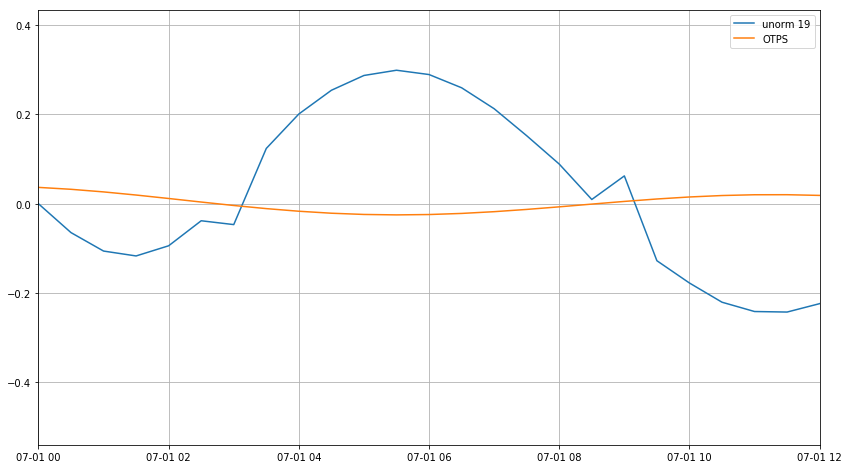

In [21]:
map_dns=utils.to_datetime( map_ds.time.values )
fig,ax=plt.subplots(figsize=(14,8))
for lay in [19]:
    ax.plot(utils.to_datetime(unorm.time.values), 
            (1/0.08786)*map_ds.unorm.isel(nFlowLink=link_idx,laydim=lay),label='unorm %d'%lay)

ax.plot(utils.to_datetime(otps_inward.time.values), otps_inward.values,label='OTPS')
ax.legend()
ax.axis(xmin=map_dns[0],xmax=map_dns[24])
ax.grid(1)

In [223]:
# See how the normals compare in general
xyflip=[]

for ji,j in enumerate(boundary_edges):
    edge_xy=edges_xy[ji] 

    dists=utils.dist(edge_xy-link_xy)
    link_idx=np.argmin(dists)

    unorm=map_ds.unorm.isel(nFlowLink=link_idx,laydim=19)
    otps_inward=otps_inwards.isel(site=ji)
    mb=np.polyfit(otps_inward.values[4:],unorm.values[4:],1)
    xyflip.append( (edge_xy[0],edge_xy[1],mb[0]) )

xyflip=np.array(xyflip)

(350000.0, 380000.0, 4200000.0, 4250000.0)

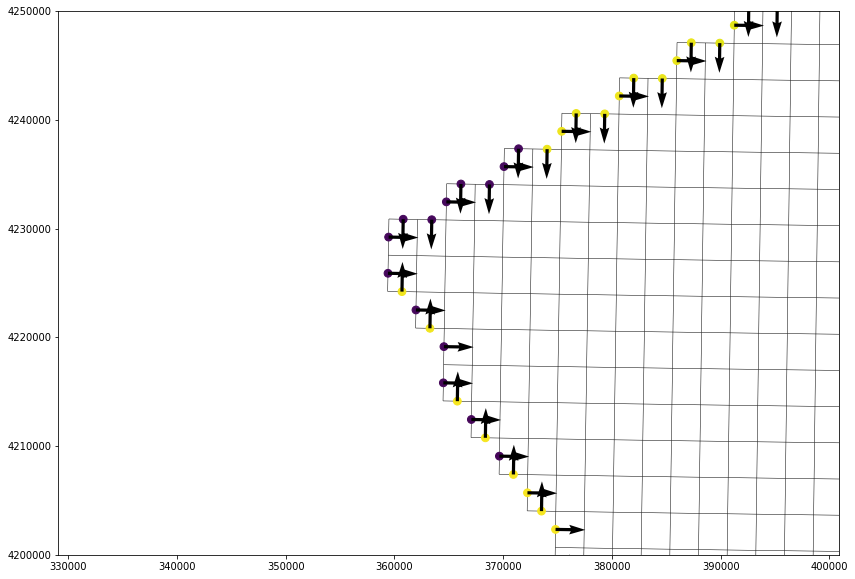

In [228]:
fig,ax=plt.subplots(figsize=(14,10))
scat=ax.scatter(xyflip[:,0],xyflip[:,1],60,xyflip[:,2])
scat.set_clim([-.1,.1])
g.plot_edges(color='k',lw=0.5,zorder=-1)

ax.quiver(edges_xy[:,0],edges_xy[:,1],edges_norm_in[:,0],edges_norm_in[:,1])
ax.axis( xmin=350e3,xmax=380e3,ymin=4.2e6, ymax=4.25e6)

Regroup on the comparison
---

The map output provides normal velocities, and let's us identify the
boundary links.  Here, 

 1. Identify boundary links
 2. Extract their lat/lons, and their inward-facing normals
 3. Run OTPS for those locations
 4. Compare unorm and OTPS
 5. optionally match a pli/tim file to each, to see if the time file reflects OTPS or unorm.
 
These steps lead to the conclusion that somewhere inside DFM, normals are not
what I expect them to be.  The normals do look appropriately inward pointing.
So it would appear that DFM has a different version of those normals.  Is it
related to other geometry in the map output?

In [98]:
# FlowLink is 1-based, with boundaries being greater than
# the number of elements.
link_is_bc= map_ds.FlowLink.values[:,0]> len(map_ds.nFlowElem)
print("There are %d BC links"%(link_is_bc.sum() ))
assert map_ds.FlowLink.values[:,1].max()<=len(map_ds.nFlowElem)

bc_link_idxs=np.nonzero(link_is_bc)[0]

There are 213 BC links


In [99]:
bc_link_xy= np.c_[ map_ds.FlowLink_xu.values[link_is_bc],
                   map_ds.FlowLink_yu.values[link_is_bc]]
bc_link_ll=utm2ll(bc_link_xy)

# centers of the elements:
elt_xy = np.c_[ map_ds.FlowElem_xcc.values, map_ds.FlowElem_ycc.values]
# inside element for each bc link, switching to 0-based
bc_elt = map_ds.FlowLink.values[link_is_bc,1] -1 

bc_link_inward_vec=elt_xy[bc_elt] - bc_link_xy
bc_link_inward_norm=utils.to_unit(bc_link_inward_vec)

(350000.0, 380000.0, 4200000.0, 4250000.0)

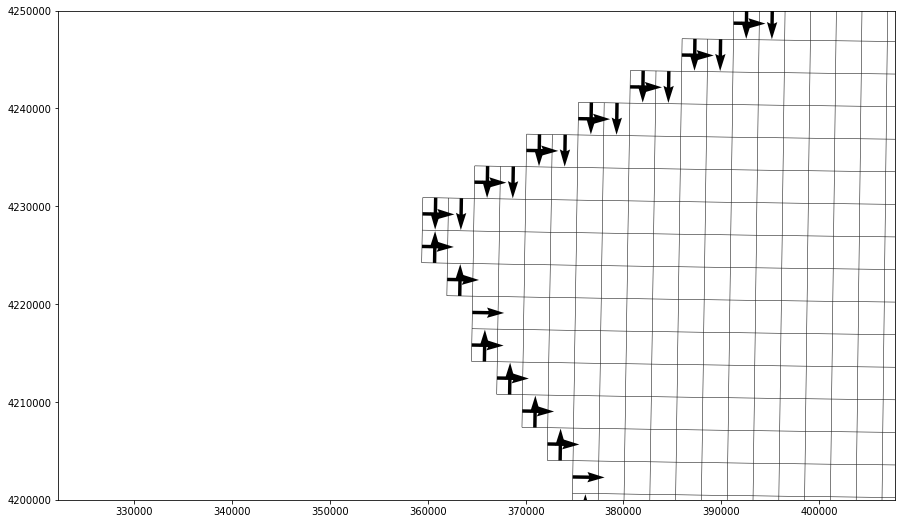

In [100]:
# Check the previous two steps graphically.  Good.
fig,ax=plt.subplots(figsize=(15,9))

g.plot_edges(ax=ax,color='k',lw=0.5)
ax.quiver( bc_link_xy[:,0],bc_link_xy[:,1],
           bc_link_inward_norm[:,0],bc_link_inward_norm[:,1])

ax.axis( xmin=350e3,xmax=380e3,ymin=4.2e6, ymax=4.25e6)

In [101]:
# Run OTPS for all boundary links.

print("u-harmonics")
u_edge_harmonics = Otps.extract_HC( bc_link_ll,quant='u' )
print("v-harmonics")
v_edge_harmonics = Otps.extract_HC( bc_link_ll,quant='v' )

u-harmonics
v-harmonics


In [102]:
# take care of cm/s conversion, too
print("Reconstruct")
u_edge=otps.reconstruct(u_edge_harmonics, map_ds.time.values) / 100.0
v_edge=otps.reconstruct(v_edge_harmonics, map_ds.time.values) / 100.0

Reconstruct


In [103]:
otps_unorm= ( u_edge.result * bc_link_inward_norm[:,0,None] +
              v_edge.result * bc_link_inward_norm[:,1,None] )
map_unorm=map_ds.unorm.isel(laydim=-1)

In [104]:
# See if there are other sources of normal vectors which 
# might be what DFM is using if u-normal

netlink_norms=[]

netlink_xy=np.c_[map_ds.NetLink_xu.values,
                 map_ds.NetLink_yu.values]
node_xy=np.c_[ map_ds.NetNode_x.values,
               map_ds.NetNode_y.values]

for bc_idx,link_idx in enumerate(bc_link_idxs):
    xy=bc_link_xy[bc_idx]
    dists=utils.dist( xy - netlink_xy)
    netlink_idx=np.argmin(dists)
    nodes=map_ds.NetLink.values[netlink_idx,:] - 1 # this starts as 1-based
    netlink_tan= node_xy[nodes[1]] - node_xy[nodes[0]]
    netlink_perp = np.array([-netlink_tan[1],netlink_tan[0]])
    netlink_norm = utils.to_unit(netlink_perp)
    netlink_norms.append(netlink_norm)
    dotP=(netlink_norm * bc_link_inward_norm[bc_idx]).sum()
    
    print("Match bc flow link %d %d to netlink %d with tol=%.2f => dot=%.3f"%(bc_idx,link_idx,
                                                                  netlink_idx,
                                                                 dists[netlink_idx],dotP))

netlink_norms=np.array(netlink_norms)



Match bc flow link 0 7312 to netlink 0 with tol=0.00 => dot=1.000
Match bc flow link 1 7313 to netlink 3 with tol=0.00 => dot=1.000
Match bc flow link 2 7314 to netlink 5 with tol=0.00 => dot=1.000
Match bc flow link 3 7315 to netlink 6 with tol=0.00 => dot=1.000
Match bc flow link 4 7316 to netlink 7 with tol=0.00 => dot=1.000
Match bc flow link 5 7317 to netlink 10 with tol=0.00 => dot=1.000
Match bc flow link 6 7318 to netlink 14 with tol=0.00 => dot=1.000
Match bc flow link 7 7319 to netlink 15 with tol=0.00 => dot=1.000
Match bc flow link 8 7320 to netlink 18 with tol=0.00 => dot=1.000
Match bc flow link 9 7321 to netlink 21 with tol=0.00 => dot=1.000
Match bc flow link 10 7322 to netlink 29 with tol=0.00 => dot=1.000
Match bc flow link 11 7323 to netlink 30 with tol=0.00 => dot=1.000
Match bc flow link 12 7324 to netlink 31 with tol=0.00 => dot=1.000
Match bc flow link 13 7325 to netlink 34 with tol=0.00 => dot=1.000
Match bc flow link 14 7326 to netlink 46 with tol=0.00 => dot=1

In [105]:
matches=[]

for bc_idx,link_idx in enumerate(bc_link_idxs):
    mb=np.polyfit( otps_unorm.isel(site=bc_idx).values[6:],
                   map_unorm.isel(nFlowLink=link_idx).values[6:],1)
    matches.append(mb[0])
    
# Confirm a mix of ~1 and ~-1
matches=np.array(matches)

/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarnin

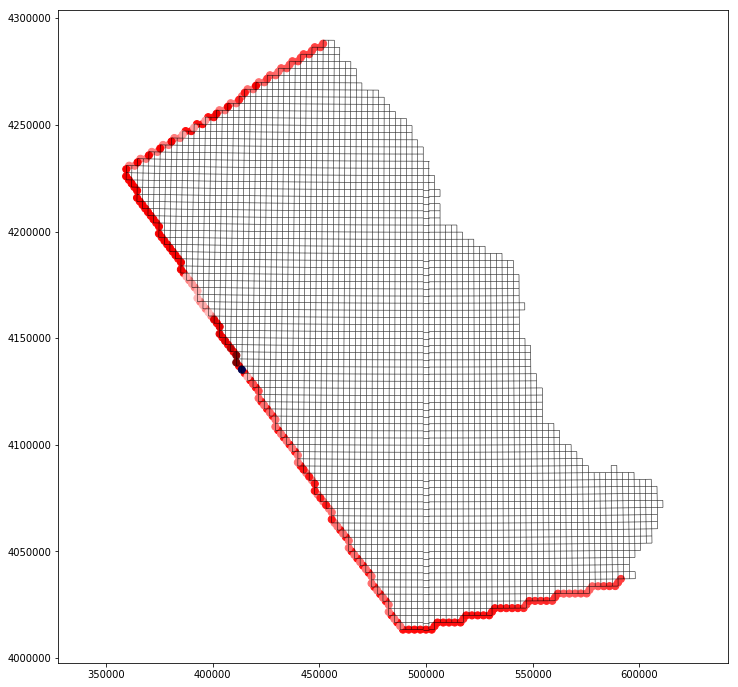

In [106]:
# Is there a spatial pattern to this? Not really.
fig,ax=plt.subplots(figsize=(12,12))
g.plot_edges(ax=ax,color='k',lw=0.5)
ax.scatter( bc_link_xy[:,0],bc_link_xy[:,1],50,matches,cmap='seismic')

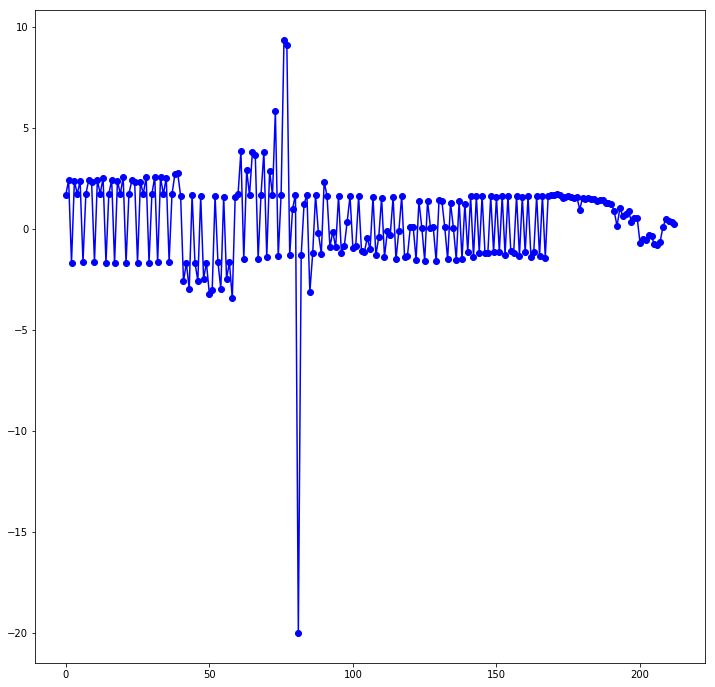

In [107]:
# sequence pattern?
fig,ax=plt.subplots(figsize=(12,12))
ax.plot(matches,'b-o')

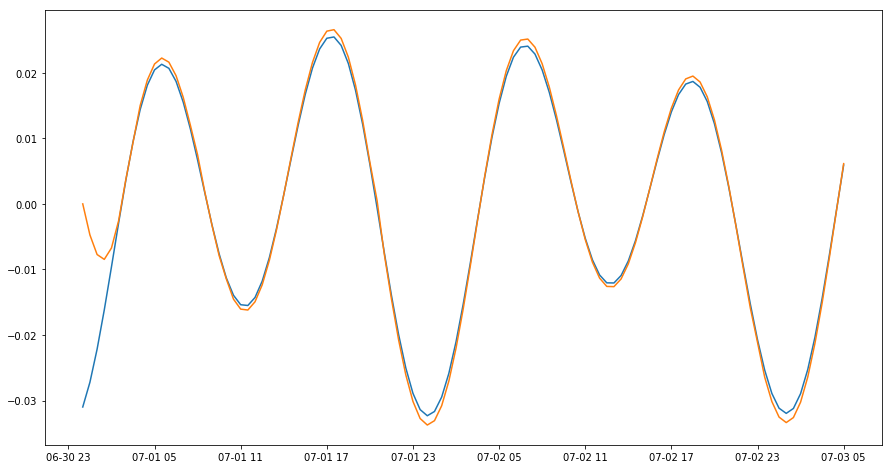

In [43]:
bc_idx=10
fig,ax=plt.subplots(figsize=(15,8))

ax.plot( utils.to_datetime(u_edge.time), otps_unorm.isel(site=bc_idx),label='OTPS')
ax.plot( utils.to_datetime(map_ds.time),
         map_unorm.isel(nFlowLink=bc_link_idxs[bc_idx]),label="Map")

In [74]:
# Read back in what was set in the input files:
# input files are labeled by the edge index in the original grid.
# need to be the grid that was used in creating the inputs
g_orig=dfm_grid.DFMGrid("runs/short_28/matched_grid_v01_net.nc")

ref_date,run_start,run_stop = mdu.time_range()

g_orig_xy=g_orig.edges_center()


match_tim_to_otps=[]
for bc_idx in range(len(bc_link_idxs)):
    link_idx=bc_link_idxs[bc_idx]
    dists = utils.dist( bc_link_xy[bc_idx] - g_orig_xy )
    j=np.argmin(dists)
    print("BC %d link=%d  match to dist=%.2f"%(bc_idx,link_idx,dists[j]))
    tim_fn="runs/short_28/oce%05d_un_0001.tim"%j
    data=np.loadtxt(tim_fn)
    tim_dt64=ref_date + data[:,0]*np.timedelta64(60,'s')
    tim_at_map_ds=np.interp( utils.to_dnum(map_ds.time.values),
                             utils.to_dnum(tim_dt64), data[:,1])
    mb=np.polyfit(tim_at_map_ds,otps_unorm.isel(site=bc_idx),1)
    match_tim_to_otps.append(mb[0])

    
if 0: # plot a single bc    
    fig,ax=plt.subplots(figsize=(15,8))

    ax.plot( utils.to_datetime(u_edge.time), otps_unorm.isel(site=bc_idx),lw=3,zorder=-1,label='OTPS')
    ax.plot( utils.to_datetime(map_ds.time),
             map_unorm.isel(nFlowLink=bc_link_idxs[bc_idx]),label="Map")
    ax.plot( utils.to_datetime(tim_dt64),
             data[:,1],label=tim_fn)
    ax.axis(xmin= utils.to_datetime(map_ds.time.values[0]),
            xmax=utils.to_datetime(map_ds.time.values[-1]))
    ax.legend()

BC 0 link=7312  match to dist=0.00
BC 1 link=7313  match to dist=0.00
BC 2 link=7314  match to dist=0.00
BC 3 link=7315  match to dist=0.00
BC 4 link=7316  match to dist=0.00
BC 5 link=7317  match to dist=0.00
BC 6 link=7318  match to dist=0.00
BC 7 link=7319  match to dist=0.00
BC 8 link=7320  match to dist=0.00
BC 9 link=7321  match to dist=0.00
BC 10 link=7322  match to dist=0.00
BC 11 link=7323  match to dist=0.00
BC 12 link=7324  match to dist=0.00
BC 13 link=7325  match to dist=0.00
BC 14 link=7326  match to dist=0.00
BC 15 link=7327  match to dist=0.00
BC 16 link=7328  match to dist=0.00
BC 17 link=7329  match to dist=0.00
BC 18 link=7330  match to dist=0.00
BC 19 link=7331  match to dist=0.00
BC 20 link=7332  match to dist=0.00
BC 21 link=7333  match to dist=0.00
BC 22 link=7334  match to dist=0.00
BC 23 link=7335  match to dist=0.00
BC 24 link=7336  match to dist=0.00
BC 25 link=7337  match to dist=0.00
BC 26 link=7338  match to dist=0.00
BC 27 link=7339  match to dist=0.00
BC

In [75]:
match_tim_to_otps=np.array(match_tim_to_otps)
match_tim_to_otps

array([ 1.00000175,  1.00016151,  0.99999825,  1.00016088,  1.00000172,
        1.00016095,  0.99999849,  1.0000017 ,  1.00015976,  1.00015999,
        0.99999829,  1.0001594 ,  1.00000167,  1.00015958,  0.99999853,
        1.00000163,  1.00015802,  0.99999834,  1.00015777,  1.00000159,
        1.00015863,  0.99999857,  1.00000155,  1.00015981,  1.00015939,
        0.99999838,  1.00015653,  1.00000152,  1.00016031,  0.99999862,
        1.00000148,  1.0001606 ,  0.99999844,  1.00015558,  1.00000145,
        1.0001608 ,  0.99999867,  1.00000143,  1.00016127,  1.00016113,
        0.9999985 ,  1.00015503,  1.0000014 ,  1.00016122,  0.99999872,
        1.00000137,  1.00016119,  0.99999857,  1.00015411,  1.00000134,
        1.00016148,  1.00016147,  0.99999879,  1.00000132,  1.00016074,
        0.99999865,  1.00015568,  1.00000129,  1.00015969,  0.99999884,
        1.00000126,  1.00015905,  0.99999869,  1.00015364,  1.00000124,
        1.0001582 ,  1.00015864,  0.99999887,  1.00000121,  1.00

In [123]:
map_ds

<xarray.Dataset>
Dimensions:                      (laydim: 20, nBndLink: 364, nFlowElem: 3747, nFlowElemContourPts: 4, nFlowLink: 7503, nFlowLinkPts: 2, nNetElem: 3747, nNetElemMaxNode: 4, nNetLink: 7676, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3930, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 1, nmesh2d_EnclosurePoints: 365, time: 281, wdim: 21)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 3.607e+05 3.608e+05 ...
    FlowElem_ycc                 (nFlowElem) float64 4.226e+06 4.229e+06 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2017-07-01 ...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetL

In [118]:
np.argmin(map_ds.FlowElem_xcc.values)

0

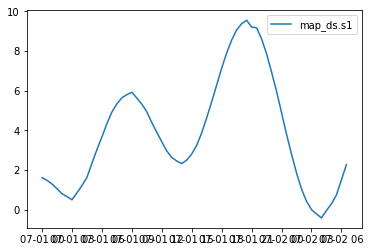

In [136]:
try:
    map_ds.close()
except NameError:
    pass
map_ds=xr.open_dataset('runs/short_29/DFM_OUTPUT_short_29/short_29_map.nc')

# Do I want the grid from the net file, or the original?
g=dfm_grid.DFMGrid(map_ds)

fig,ax=plt.subplots()
ax.plot(utils.to_datetime(map_ds.time.values),
        map_ds.s1.isel(nFlowElem=0),label='map_ds.s1')
ax.legend()